# Hodgkin-Huxley model specifications
This lays out the parameterizations for the HH point cells for the event-based encodings manuscript.

In [1]:
import sys
import numpy as np
import random
import pandas as pd
from neuron import h
h.load_file("stdrun.hoc")

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
sys.path.insert(1, "../utils/")
import HH, WB, Stimuli

from scipy.spatial import distance

from neuron import h
h.load_file("stdrun.hoc")
from neuron.units import mV, ms

## generate stimuli

In [2]:
sim_duration = 100000

stim_types = ['base','lw','lt','lwlt','burst']

e_times = Stimuli.poisson_process_duration(5, sim_duration)
i_times = Stimuli.poisson_process_duration(15, sim_duration)

In [3]:
figures_dir = '../figures/'

## Set up point cell models

In [4]:
stim_params = Stimuli.ExperimentalStimParams()
stim_scaffold = stim_params.stim_scaffold

for stim_type in stim_scaffold:
    stim_scaffold[stim_type]['ex'].stim_times = e_times
    stim_scaffold[stim_type]['in'].stim_times = i_times

In [5]:
sims = {stim_type:HH.HH() for stim_type in stim_types}

for stim_type in stim_types:
    sims[stim_type].add_custom_stimulus(stim_scaffold[stim_type]['ex'])
    sims[stim_type].add_custom_stimulus(stim_scaffold[stim_type]['in'])
h.celsius = 6.3
sims[stim_type].run_simulation(sim_duration)

# commit state variables before running WB model
state_vars = {}
spikes = {}
for stim_type in sims:
    state_vars[stim_type] = np.array(
        [sims[stim_type]._v, sims[stim_type]._m, sims[stim_type]._h, sims[stim_type]._n]
    )
    spikes[stim_type] = list(sims[stim_type].spike_times)

In [6]:
# Wang Buzsaki model
stim_scaffold['wb']['ex'].stim_times = e_times
stim_scaffold['wb']['in'].stim_times = i_times
wb = WB.WB()
wb.add_custom_stimulus(stim_scaffold['wb']['ex'])
wb.add_custom_stimulus(stim_scaffold['wb']['in'])
h.celsius = 37
wb.run_simulation(sim_duration)

state_vars['wb'] = np.array([wb._v, wb._m_kdr, wb._h_naf])
spikes['wb'] = list(wb.spike_times)
t = wb._t

In [7]:
colors = {
    'base':'maroon',
    'lw':'orangered',
    'lt':'darkgreen',
    'lwlt':'teal',
    'burst':'indigo',
    'wb':'black'
}

## General Statistics

In [8]:
for stim_type in spikes:
    isis = [spikes[stim_type][i+1] - spikes[stim_type][i] for i in range(len(spikes[stim_type])-1)]

    print(stim_type)
    print(f'\taverage spike frequency: {len(spikes[stim_type]) / (sim_duration / 1000)} Hz')
    print(f'\tcoefficient of variation (CV) of ISIs: {np.std(isis) / np.mean(isis)}')
    print()

base
	average spike frequency: 22.29 Hz
	coefficient of variation (CV) of ISIs: 0.6648980488101643

lw
	average spike frequency: 14.97 Hz
	coefficient of variation (CV) of ISIs: 0.8054454752242441

lt
	average spike frequency: 18.19 Hz
	coefficient of variation (CV) of ISIs: 0.8077415571401335

lwlt
	average spike frequency: 23.43 Hz
	coefficient of variation (CV) of ISIs: 0.6826860210397747

burst
	average spike frequency: 31.09 Hz
	coefficient of variation (CV) of ISIs: 0.8360431192945577

wb
	average spike frequency: 25.03 Hz
	coefficient of variation (CV) of ISIs: 0.682457174412738



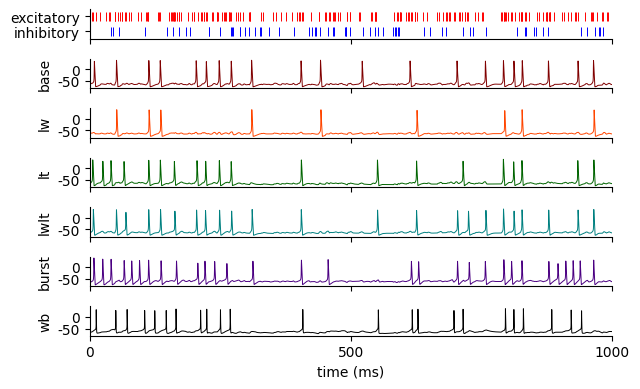

In [38]:
fig, axes = plt.subplots(7,1, figsize=(6.5,4), sharex=True)

axes[0].vlines(e_times, .2, .8, color='red', linewidth=.7)
axes[0].vlines(i_times, -.8, -.2, color='blue', linewidth=.7)
axes[0].set_ylim(-1,1)
axes[0].set_yticks([.5,-.5])
axes[0].set_yticklabels(['excitatory','inhibitory'])
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

for ax, stim_type in enumerate(state_vars):
    axes[ax+1].plot(t, state_vars[stim_type][0,:], c=colors[stim_type], linewidth=.7)
    axes[ax+1].set_ylabel(stim_type)
    
    axes[ax+1].spines['right'].set_visible(False)
    axes[ax+1].spines['top'].set_visible(False)
    
    axes[ax+1].set_yticks([-50,0])
    axes[ax+1].set_yticklabels([-50, 0])

xlim = 1000
axes[-1].set_xlim(0, xlim)
axes[-1].set_xlabel('time (ms)')

xticks = np.arange(0,xlim+1, 500)
axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels(xticks)

plt.tight_layout()

savefig = True
if savefig:
    plt.savefig(f'{figures_dir}point_cell_traces_with_WB.svg', format='svg')
    plt.savefig(f'{figures_dir}point_cell_traces_with_WB.png', format='png', dpi=300)

plt.show()

## median histories

In [11]:
def standarize_column(column):
    # set column to fit in (0,1)
    column = column-np.min(column)
    column = column/np.max(column)
    return column

def get_median_history(state_vars):
    # state_vars: np array

    # calculate the median of each state variable
    median_values = np.median(state_vars, axis = 1)
    
    dists = []
    for i in range(state_vars.shape[1]):
        dists.append(distance.euclidean(state_vars[:,i], median_values))

    return state_vars[:, np.argmin(dists)]

def isolate_spiking_histories(state_vars, spikes):
    spiking_histories = []
    for spike in spikes:
        row = round(40 * spike)
        spiking_histories.append(state_vars[:,row])                              
    return np.array(spiking_histories)

In [12]:
median_histories = {}
spiking_histories = {}

for stim_type in state_vars:
    print(stim_type)
    median_histories[stim_type] = get_median_history(state_vars[stim_type])
    spiking_histories[stim_type] = isolate_spiking_histories(state_vars[stim_type], spikes[stim_type])

base
lw
lt
lwlt
burst
wb


drawing base
drawing lw
drawing lt
drawing lwlt
drawing burst
drawing wb


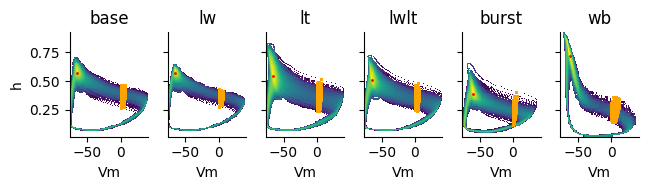

In [39]:
fig, axes = plt.subplots(1,6, figsize=(6.5, 2), sharex=True, sharey=True)

ax_ind = 0
for stim_type in stim_types + ['wb']:
    print(f'drawing {stim_type}')
    
    axes[ax_ind].hist2d(state_vars[stim_type][0,:], state_vars[stim_type][2,:], 
                        bins=80, cmin=1, norm=mpl.colors.LogNorm())
    # median history
    med_history = median_histories[stim_type]
    axes[ax_ind].scatter(med_history[0], med_history[2], c='red', s=1)
    # spiking history
    spike_histories = spiking_histories[stim_type]
    
    for i in range(spike_histories.shape[0]):
        axes[ax_ind].scatter(spike_histories[:,0], spike_histories[:,2], c='orange', alpha=1, s=.2)
    
    
    axes[ax_ind].set_title(stim_type)
    axes[ax_ind].set_xlabel('Vm')
    
    axes[ax_ind].spines['top'].set_visible(False)
    axes[ax_ind].spines['right'].set_visible(False)
    ax_ind += 1
    
axes[-1].set_xlim(
    np.min(np.array([state_vars[stim_type][0,:] for stim_type in stim_types+['wb']])),
    np.max(np.array([state_vars[stim_type][0,:] for stim_type in stim_types+['wb']]))
)
axes[-1].set_ylim(
    np.min(np.array([state_vars[stim_type][2,:] for stim_type in stim_types+['wb']])),
    np.max(np.array([state_vars[stim_type][2,:] for stim_type in stim_types+['wb']]))
)

axes[0].set_ylabel('h')

plt.tight_layout()

savefig = True
if savefig:
    plt.savefig(f'{figures_dir}point_cell_manifolds_with_WB.png', format='png', dpi=300)

plt.show()